In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Test if GPU is active
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import keras
import time
import h5py    
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
from keras.models import load_model
from keras.models import Sequential

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Import data and label files

# Train labels
training_labels_downloaded = drive.CreateFile({'id': '1rJCglyD-6uTow7RFsj5K7WxSl1YFyg8M'})
training_labels_downloaded.GetContentFile('train.txt')
train_labels = pd.read_csv('train.txt', sep=" ", header=None)

# Test labels
test_labels_downloaded = drive.CreateFile({'id': '15a5U1SsguFSdQim7ifoA9vpuhyL5AgTZ'})
test_labels_downloaded.GetContentFile('vali.txt')
test_labels = pd.read_csv('vali.txt', sep=" ", header=None)

# Train data
train_data_downloaded = drive.CreateFile({'id': '1-X94bMCmjMShVVN5VJXPZ936Zly0BOP_'})
train_data_downloaded.GetContentFile('train-set.zip')
train_data = zipfile.ZipFile('train-set.zip', 'r')
train_data.extractall()

# Test data
test_data_downloaded = drive.CreateFile({'id': '1lSMxDwZFD40ceFAlWCoqT1TlJ9gqgqOx'})
test_data_downloaded.GetContentFile('vali-set.zip')
test_data = zipfile.ZipFile('vali-set.zip', 'r')
test_data.extractall()

###**1. Learn features from **train** and test sets using VGG16's pre-trained convolution layers**

In [5]:
# Adapted from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# Import pre-trained VGG16 model without fully-connected layers
vgg16_model = applications.VGG16(include_top=False, weights='imagenet')

# Directory of training and test set
train_directory = 'train-set'
vali_directory = 'vali-set'
# Samples counts
train_samples = 37882
vali_samples = 6262
batch_size = 31

# Define a data generator for rescaling
rescale_data = ImageDataGenerator(rescale=1. / 255)

58892288/58889256 [==============================] - 1s 0us/step


In [6]:
# Learn features from train set - should take roughly 3 minutes
start = time.time()
train_generator = rescale_data.flow_from_directory(
    train_directory,
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    shuffle=False)

train_features = vgg16_model.predict_generator(train_generator, train_samples // batch_size)
end = time.time()
print('Total train time is {:0.2f} minutes'.format(int(end-start)/60))

Found 37882 images belonging to 1 classes.
Total train time is 3.22 minutes


In [7]:
# Learn features from test set - should take roughly 1 minute
start = time.time()
vali_generator = rescale_data.flow_from_directory(
    vali_directory,
    target_size=(150, 150),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    shuffle=False)

validation_features = vgg16_model.predict_generator(vali_generator, vali_samples // batch_size)
end = time.time()
print('Total test time is {:0.2f} minutes'.format(int(end-start)/60))

Found 6262 images belonging to 1 classes.
Total test time is 0.52 minutes


###**2. Train our model of fully-connected layers using the outputs from VGG16's convolution layers**

In [8]:
# Define training and test sets for our model

# Train data
X_train = train_features
y_train = train_labels[1][:]
y_train = keras.utils.to_categorical(y_train,62)
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)

# Test data
X_test = validation_features
y_test = test_labels[1][:]
y_test = keras.utils.to_categorical(y_test,62)
print('X_test:',X_test.shape)
print('y_test:',y_test.shape)

X_train: (37882, 4, 4, 512)
y_train: (37882, 62)
X_test: (6262, 4, 4, 512)
y_test: (6262, 62)


In [ ]:
# Define our model
start = time.time()
model = Sequential()
model.add(Flatten(input_shape=(4,4,512)))
# Two fully-connected layers of 4096 channels with dropout after each
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.7))
# Fully-connected layer of 62 channels for 62 classes
model.add(Dense(62, activation='softmax'))

# Define Adam optimizer
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

# Compile the model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to save the model to h5 file whenever a max val_acc is reached
save_call = keras.callbacks.ModelCheckpoint('Model.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='max', period=1)

# Train the model and save its history
history = model.fit(X_train, y_train,
          epochs=200,
          batch_size=2048,
          validation_data=(X_test, y_test),
          callbacks=[save_call])

# Calculate accuracy, loss of epoch 200
score = saved_model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {:0.2f}%'.format(score[0]*100))
print('Test accuracy: {:0.2f}%'.format(score[1]*100))

end = time.time()
print('Total time is {:0.2f} minutes'.format(int(end-start)/60))


Train on 37882 samples, validate on 6262 samples
Epoch 1/200
37882/37882 [==============================] - 7s 173us/step - loss: 2.2195 - acc: 0.4483 - val_loss: 0.6438 - val_acc: 0.8047
Epoch 2/200
37882/37882 [==============================] - 5s 135us/step - loss: 0.7450 - acc: 0.7736 - val_loss: 0.4842 - val_acc: 0.8417
Epoch 3/200
37882/37882 [==============================] - 5s 136us/step - loss: 0.5826 - acc: 0.8109 - val_loss: 0.4183 - val_acc: 0.8536
Epoch 4/200
37882/37882 [==============================] - 5s 137us/step - loss: 0.5121 - acc: 0.8256 - val_loss: 0.3774 - val_acc: 0.8609
Epoch 5/200
37882/37882 [==============================] - 5s 136us/step - loss: 0.4687 - acc: 0.8352 - val_loss: 0.3582 - val_acc: 0.8670
Epoch 6/200
37882/37882 [==============================] - 5s 136us/step - loss: 0.4321 - acc: 0.8475 - val_loss: 0.3376 - val_acc: 0.8726
Epoch 7/200
32768/37882 [========================>.....] - ETA: 0s - loss: 0.4102 - acc: 0.849037882/37882 [=========

### **3. Evaluation and visualisation**

In [9]:
# Load our final model
model_file = drive.CreateFile({'id': '1qO_PUBl6GL5SUP6hm1dDKMBQZ6X7ZZ10'})
model_file.GetContentFile('Final_Model.h5')
final_model = load_model('Final_Model.h5')

# Calculate accuracy, loss
score = final_model.evaluate(X_test, y_test, verbose=0)
print('Test loss: {:0.2f}%'.format(score[0]*100))
print('Test accuracy: {:0.2f}%'.format(score[1]*100))


Test loss: 21.06%
Test accuracy: 92.37%


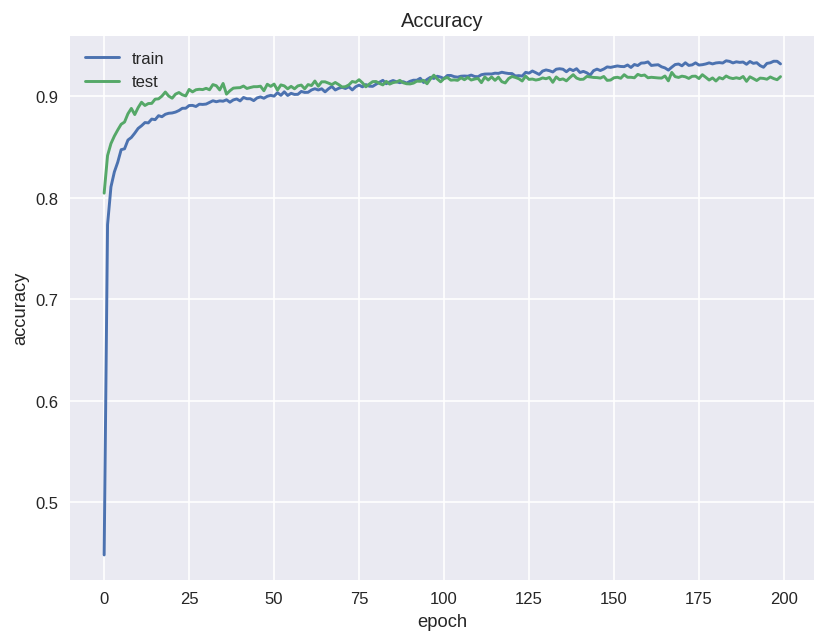

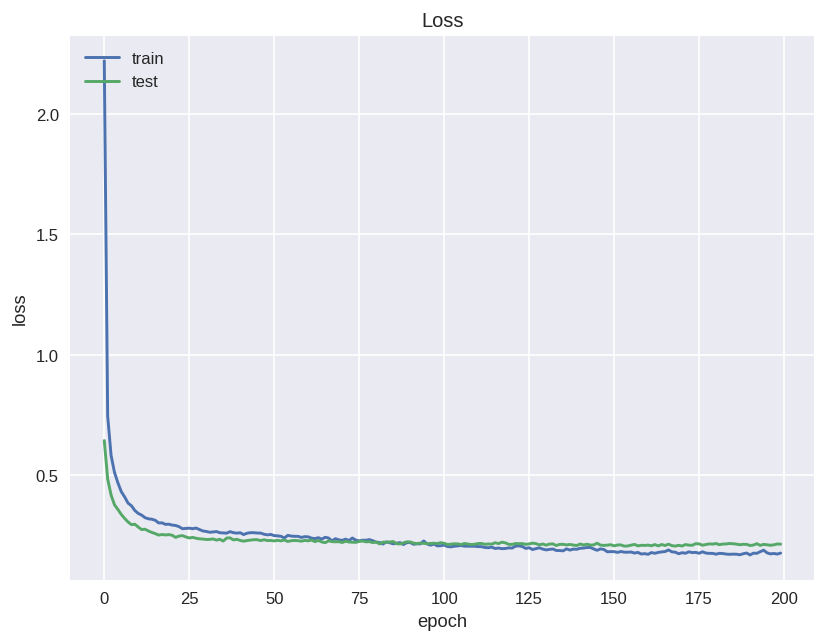

In [ ]:
# Plot accuracy 
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 120
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1]:
#Check Memory adapted from : https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  I Proc size: 146.6 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB
